# Simulate acoustic wave propagation of piston source aberrated by a cuboid slab

The OptimUS library provides functionality to simulate acoustic wave propagation in unbounded domains with homogeneous scatterers. This notebook demonstrates a simulation with a circular piston source aberrated by a cuboid slab with the properties of skull bone.

Warning: this notebook may take long to run on some computers.

## Import the OptimUS library

Load the OptimUS library.

In [1]:
import optimus

## Specify a spherical section bowl as acoustic source

The OptimUS library provides different predefined wave fields, among which is a spherical section bowl source radiating in 2*pi space. The bowl requires the frequency, outer radius and radius of curvature to be specified and, optionally, the source axis, the velocity and its location, which is in this case at [0, 0, 0].

In [2]:
frequency = 500e3
radius = 0.01
location = (0, 0, 0)
velocity = 0.04
source = optimus.source.create_piston(frequency, radius=radius, location=location, source_axis=(0, 0, 1),
                                    velocity=velocity)

We use the multiprocessing Python library for parallelisation of the incident field calculation, which increases performance on large RAM (~256 GB) multiple CPU workstations. Also increase the maximum number of GMRES iterations.

In [3]:
optimus.global_parameters.incident_field_parallelisation.parallelisation_method = "multiprocessing"
optimus.global_parameters.incident_field_parallelisation.print()
optimus.global_parameters.linalg.maxiter = 5000
optimus.global_parameters.linalg.print()

Parallelisation method is:  multiprocessing
Number of CPU used in parallelisation: 8
Memory allocation per core [MB]: 110
Linear solver: gmres
Tolerance: 1e-05
Maximum number of iterations: 5000
Number of iterations before restart: 1000


## Specify the physical settings for the simulation

Let us consider a skull slab embedded in an unbounded region of non-attenuating water. We create material properties so that they match those in the benchmarking exercise in https://doi.org/10.1121/10.0013426

In [4]:
material_ext = optimus.material.create_material(name='water-no-attenuation',
                                                   density=1000,
                                                   speed_of_sound=1500)
material_int = optimus.material.create_material(name='cortical-bone-itrusst',
                                                   density=1850,
                                                   speed_of_sound=2800,
                                                   attenuation_coeff_a=184.2,
                                                   attenuation_pow_b=2)

## Print material properties

In [5]:
material_ext.print()
material_int.print()

                 name  density  speed_of_sound  attenuation_coeff_a  attenuation_pow_b
 water-no-attenuation   1000.0          1500.0                  0.0                0.0
                  name  density  speed_of_sound  attenuation_coeff_a  attenuation_pow_b
 cortical-bone-itrusst   1850.0          2800.0                184.2                2.0


## Import grid of cuboid slab

An element edge of 0.5-0.75 mm is used here, employing a graded mesh for faster run times

In [6]:
geometry = optimus.geometry.load.import_grid("cuboid70x70x6p5mm_graded_0p75mm_0p5mm.msh", label="skull_slab")

## Simulate the wave model

The OptimUS library uses the Boundary Element Method to simulate acoustic wave propagation. Let us use a model with default settings.

In [7]:
model = optimus.model.create_default_model(source, geometry, material_ext, material_int)

After creating the model, it needs to be solved to obtain the surface potentials at the material interface. Depending on the size of the model, this can be computationally expensive. The solution will be stored inside the model object.

In [8]:
%%time
model.solve()

KeyboardInterrupt: 

## Visualisation of the acoustic field

The acoustic field can be calculated at arbitrary points. Let us visualise the field on a grid in the plane $x=0$. We increase the default posprocesing quadrature order to 20 (default = 4), for improved accuracy of the total pressure calculation.

In [9]:
%%time
optimus.global_parameters.postprocessing.quadrature_order = 20
postprocess_plane = optimus.postprocess.VisualisePlane(model)
postprocess_plane.create_computational_grid(resolution=(141, 241), bounding_box=(-0.035, 0.035, 0.0, 0.12),
                                            plane_axes=(1, 2))
postprocess_plane.compute_fields()

CPU times: user 3d 1h 50min 26s, sys: 1d 14h 2min 13s, total: 4d 15h 52min 39s
Wall time: 1h 47min 15s


Let us first visualise the incident field in the exterior domain.

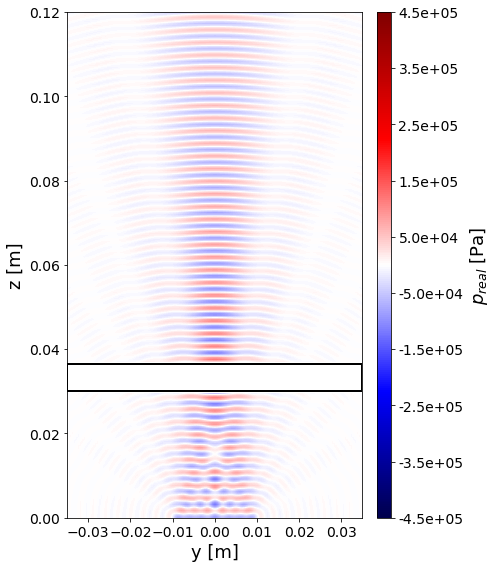

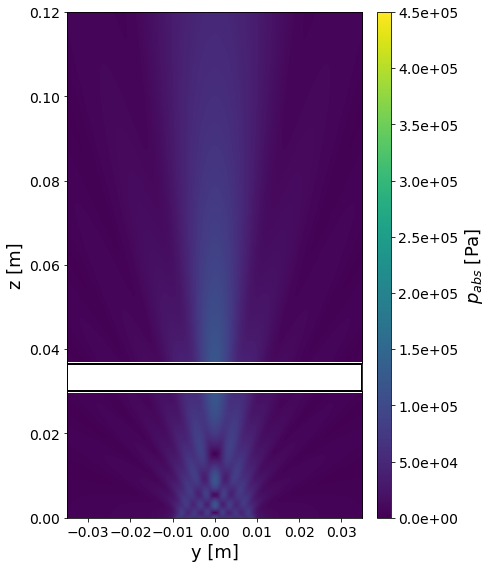

In [10]:
%matplotlib inline
figs = optimus.postprocess.plot_pressure_field(postprocess_plane, field="incident", clim=(-0.45e6, 0.45e6))

The pressure field in the entire domain is as follows.

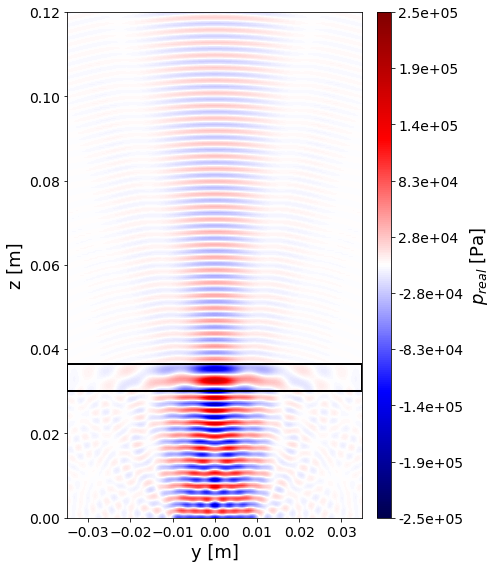

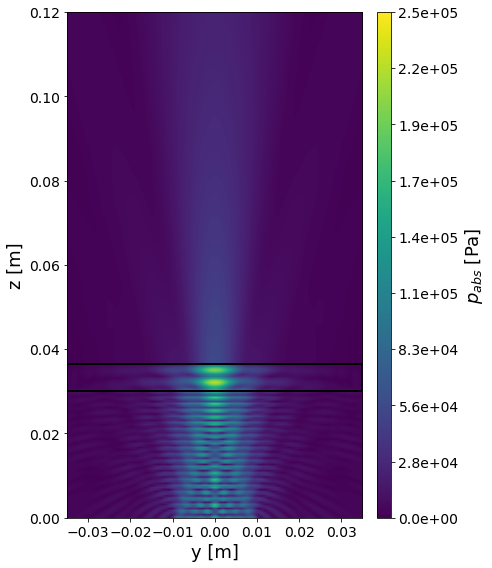

In [11]:
figs = optimus.postprocess.plot_pressure_field(postprocess_plane, field="total", clim=(-0.25e6, 0.25e6))